In [20]:
%load_ext autoreload
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, Grayscale
from torchvision.datasets import MNIST, CIFAR10 
from torch.utils.data import DataLoader, Subset, TensorDataset
from sklearn.model_selection import StratifiedShuffleSplit
from parallel import DataParallelModel, DataParallelCriterion

%autoreload 2
from networks import *
from utils import *
from losses import *
from landscape import *
from datasets import *

import matplotlib.pyplot as plt
import progressbar
import random

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Training Setup

In [27]:
# Set seed, clear cache and enable anomaly detection (for debugging)
set_seed(42)
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)


# Set training static parameters and hyperparameters
nepochs=100
dims_latent = 32                            
learning_rate=1e-3
batch_size=32                                        
device=set_device("cuda")
train_size=0.00108

Cuda installed! Running on GPU 0 GeForce RTX 2080 Ti!


In [26]:
# Training loop
def train_model(model, optimizer, train_loader, nepochs=150, switch_at_epoch=0, vis_frequency=10):
    print("\n\nTraining started ...")
    all_loss, all_mse, all_kl = [], [], []
    with progressbar.ProgressBar(max_value=nepochs) as bar:    
        for epoch in range(nepochs):
            epoch_loss, epoch_kl = train(model, train_loader, optimizer, awi2D, device=device)
            
            mse = nn.MSELoss(reduction="mean")
            mse = DataParallelCriterion(mse, device_ids=[0,1])
            epoch_mse = validate(model, train_loader, mse, device=device)
            
            all_loss.append(epoch_loss.item())
            all_mse.append(epoch_mse.item())
            all_kl.append(epoch_kl.item())
            bar.update(epoch)
                

            # Metric logs and plots
            log = {"epoch": epoch, "train_mse":epoch_mse.item(), "train_awi1d_loss": epoch_loss.item(), "train_kl_loss": epoch_kl.item()}
            if epoch % vis_frequency == 0 or epoch==nepochs-1:
                idx = random.randint(0, len(trainds))
                idx=-1
                X = trainds[idx][0].unsqueeze(0).to(device)
                recon = model(X)[0]
                v: recon = recon[0] # in case model returns more than one output, recon must be the first
                
                f = awi2D_serial(recon, X)
                v, T = awi2D_serial.v_all[0], awi2D_serial.T_arr

                print("\n", log)
                print(" argidx T, v: ",torch.argmax(torch.abs(T)).item(), torch.argmax(torch.abs(v)).item())

                plot_grad_flow(model.named_parameters())

                fig, axs = plt.subplots(2,3)
                axs[0, 0].imshow(recon[0, 0].cpu().detach().numpy(), cmap="gray", vmin=0, vmax=1.)
                axs[0, 0].set_title("recon")

                axs[0, 1].imshow(X[0, 0].cpu().detach().numpy(), cmap="gray", vmin=0, vmax=1.)
                axs[0, 1].set_title("orig")

                axs[0, 2].imshow(X[0, 0].cpu().detach().numpy() - recon[0, 0].cpu().detach().numpy(), vmin=-0.5, vmax=0.5)
                axs[0, 2].set_title("diff")

                axs[1, 0].imshow(T.detach().cpu().numpy())
                axs[1, 0].set_title("T-2D")

                axs[1, 1].imshow(v.detach().cpu().numpy())
                axs[1, 1].set_title("v-2D")

                axs[1, 2].plot((T.flatten() - v.flatten()).detach().cpu().numpy())
                axs[1, 2].set_ylim(None, 1.1)
                axs[1, 2].set_title("T2D - v2D")

                plt.show()

                fig, axs = plt.subplots(1,3, figsize=(7, 3))
                axs[0].plot(all_loss, label="aw_loss2d")
                axs[0].legend()
                axs[0].set_xlabel("epoch")
                axs[1].plot(all_mse, label="mse")
                axs[1].legend()
                axs[1].set_xlabel("epoch")
                axs[2].plot(all_kl, label="kl_loss")
                axs[2].legend()
                axs[2].set_xlabel("epoch")
                plt.show()

# MNIST Example

## Datasets and Dataloaders

In [23]:
# Datasets and dataloaders
train_transform = Compose([
    Resize(28),
    ToTensor(),
])

ds = MNIST("./", download=True, train=True, transform=train_transform)
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=1-train_size, random_state=42).split(ds.data, ds.targets)
train_idx, valid_idx = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

X_train, y_train = ds.data[train_idx] / 255., ds.targets[train_idx]
trainds = TensorDataset(X_train.unsqueeze(1).float(), y_train.float())

train_loader = DataLoader(trainds, batch_size=batch_size, shuffle=True, num_workers=4)

X = trainds[0][0].unsqueeze(0).to(device) # a sample for check ups
print("Trainable Images:", len(trainds))
print(X.shape, X.min().item(), X.max().item())


Trainable Images: 64
torch.Size([1, 1, 28, 28]) 0.0 0.9960784316062927


## Autoencoder (FC)

torch.Size([1, 1, 28, 28]) torch.Size([1, 1, 28, 28])
1


Training started ...


/home/dekape/miniconda3/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'train_mse': 0.4621860384941101, 'train_awi1d_loss': 22.615711212158203, 'train_kl_loss': 0.0}
 argidx T, v:  1512 752


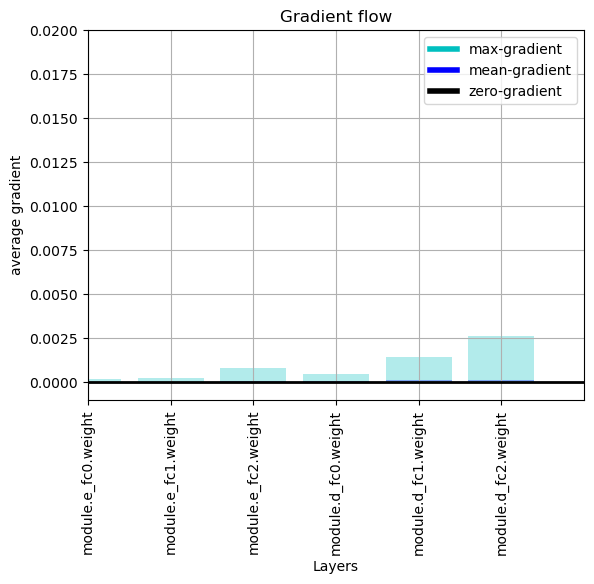

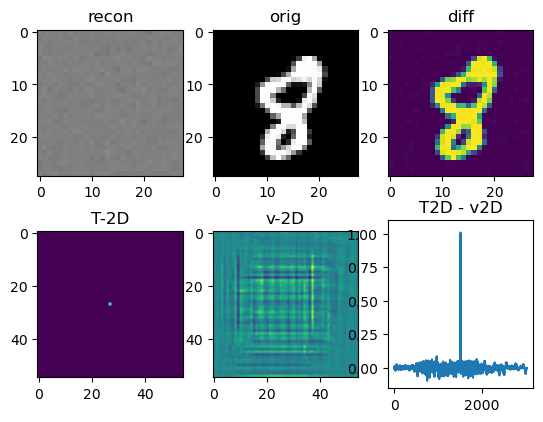

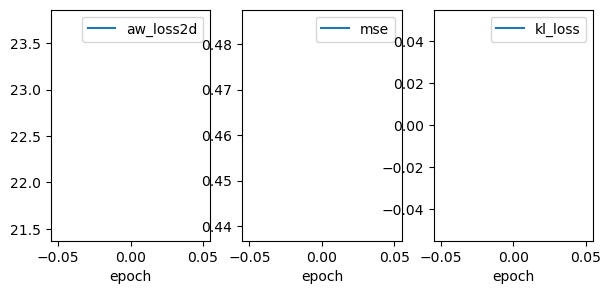

/home/dekape/miniconda3/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 20% (20 of 100) |####                   | Elapsed Time: 0:01:22 ETA:   0:05:23


 {'epoch': 20, 'train_mse': 0.3178729712963104, 'train_awi1d_loss': 19.817705154418945, 'train_kl_loss': 0.0}
 argidx T, v:  1512 1512


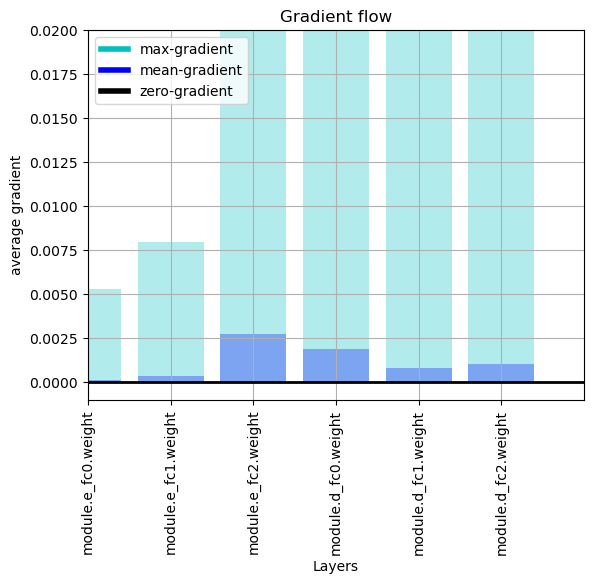

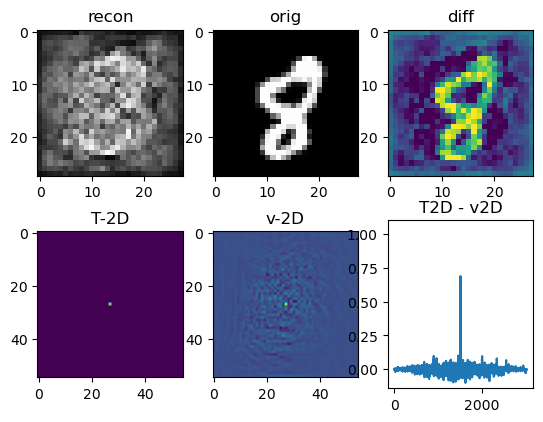

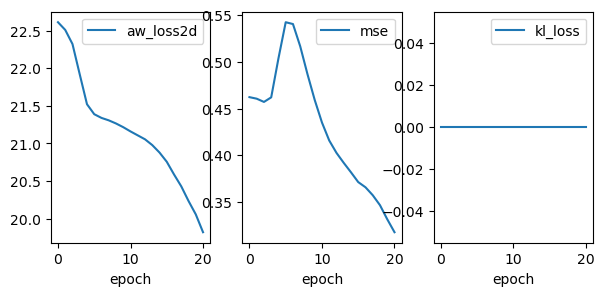

/home/dekape/miniconda3/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 40% (40 of 100) |#########              | Elapsed Time: 0:02:45 ETA:   0:04:07


 {'epoch': 40, 'train_mse': 0.16907721757888794, 'train_awi1d_loss': 14.984221458435059, 'train_kl_loss': 0.0}
 argidx T, v:  1512 1512


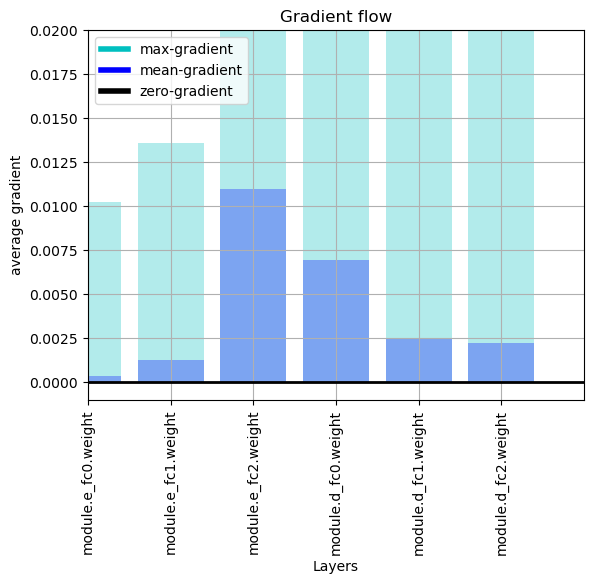

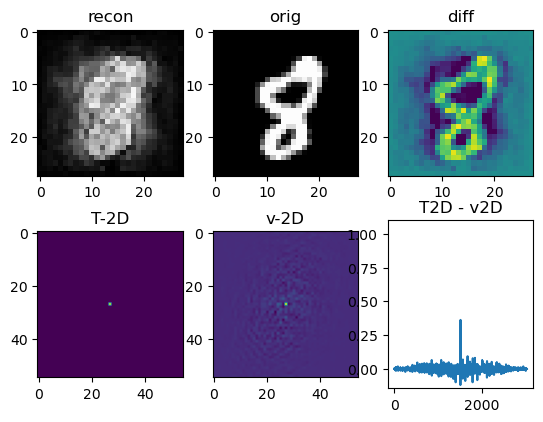

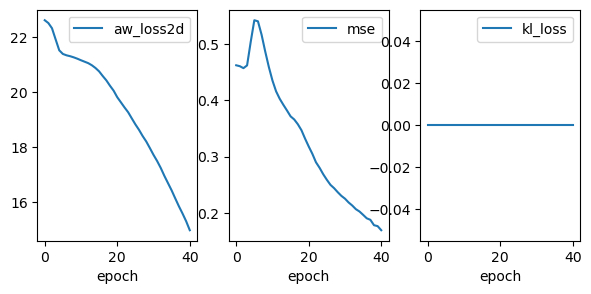

/home/dekape/miniconda3/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 60% (60 of 100) |#############          | Elapsed Time: 0:04:07 ETA:   0:02:44


 {'epoch': 60, 'train_mse': 0.09297049045562744, 'train_awi1d_loss': 9.57197093963623, 'train_kl_loss': 0.0}
 argidx T, v:  1512 1512


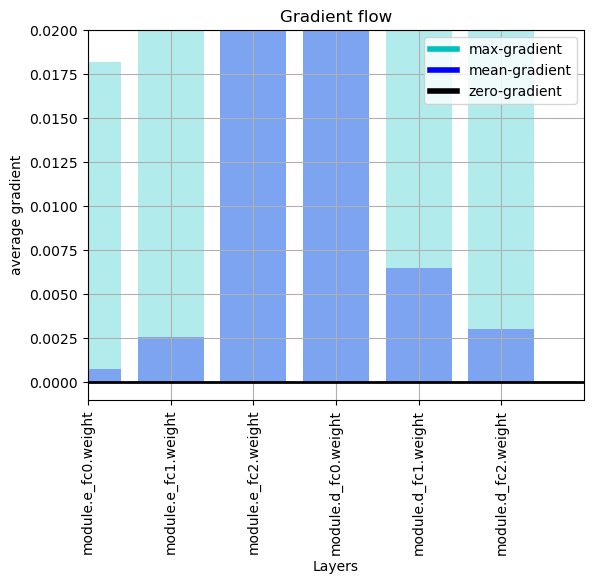

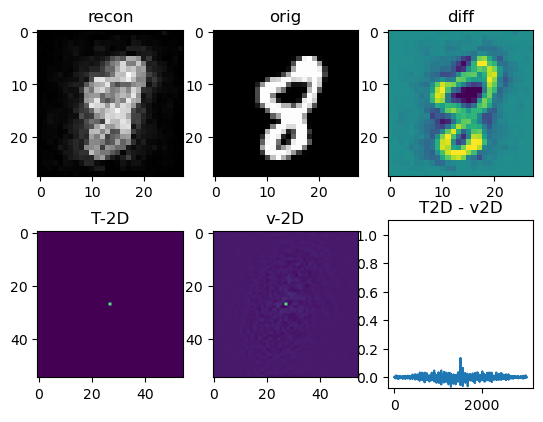

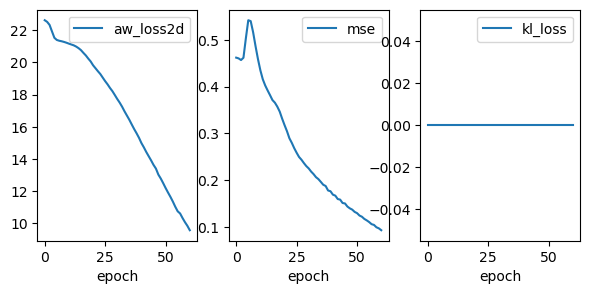

/home/dekape/miniconda3/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 80% (80 of 100) |##################     | Elapsed Time: 0:05:30 ETA:   0:01:22


 {'epoch': 80, 'train_mse': 0.04937237501144409, 'train_awi1d_loss': 6.6351728439331055, 'train_kl_loss': 0.0}
 argidx T, v:  1512 1512


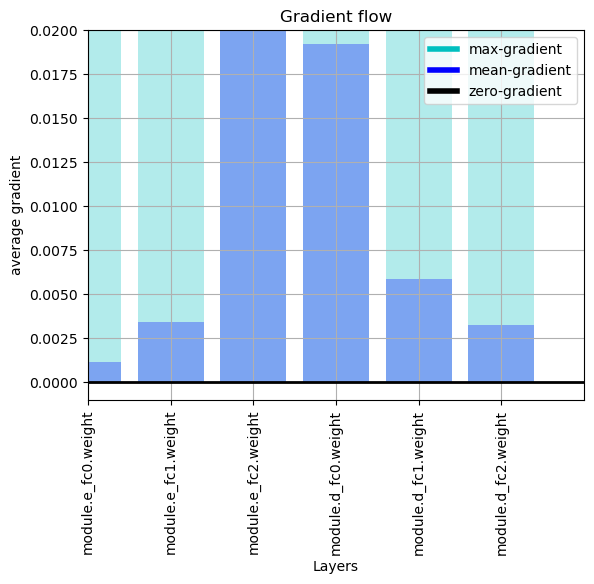

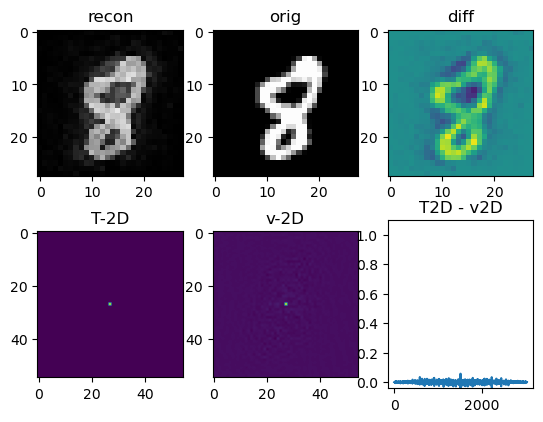

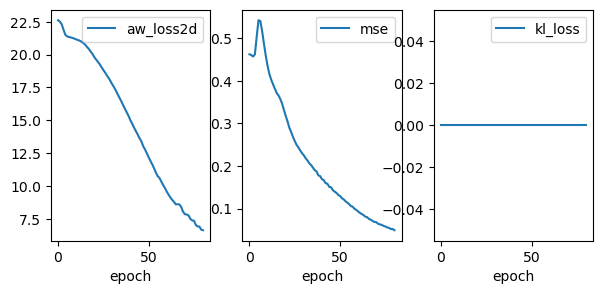

/home/dekape/miniconda3/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 99% (99 of 100) |###################### | Elapsed Time: 0:06:50 ETA:   0:00:04


 {'epoch': 99, 'train_mse': 0.03133631870150566, 'train_awi1d_loss': 5.3747735023498535, 'train_kl_loss': 0.0}
 argidx T, v:  1512 1512


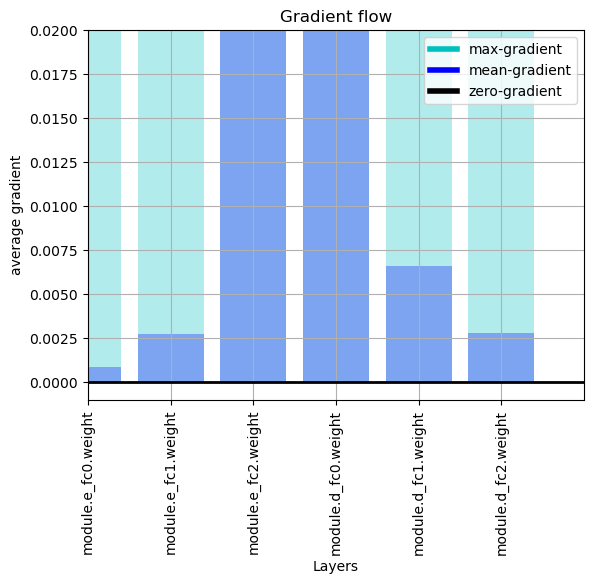

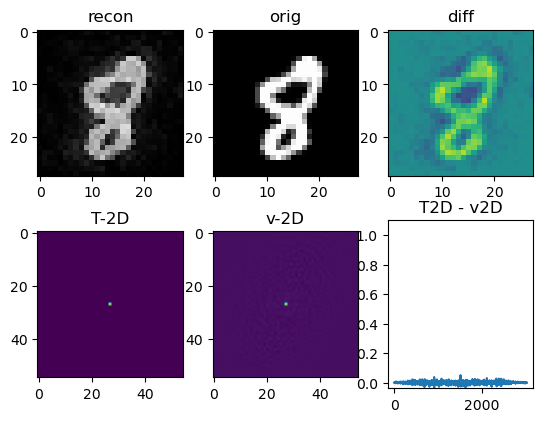

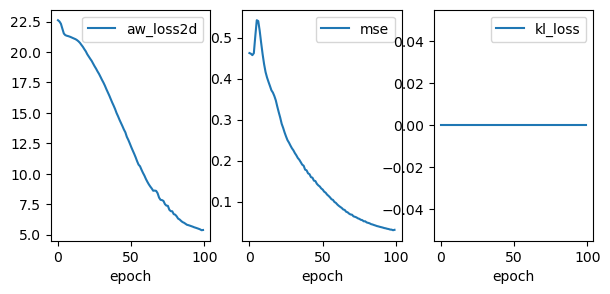

100% (100 of 100) |######################| Elapsed Time: 0:06:50 Time:  0:06:50


In [24]:
# Model and optimisers
model = Autoencoder(dims_latent=dims_latent, nc=X.shape[1]).to(device)
model = DataParallelModel(model, device_ids=[0,1])
awi2D_serial     = AWLoss2D(reduction="sum", std=1e-4, store_filters=True, alpha=0.02)
awi2D            = DataParallelCriterion(awi2D_serial, device_ids=[0,1])
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X)[0].shape)
print(len(model(X)))

# Train and visualise
train_model(model, optimizer, train_loader, nepochs, switch_at_epoch, vis_frequency=20)

## Autoencoder (CNN)

torch.Size([1, 1, 28, 28]) torch.Size([1, 1, 28, 28])
1


Training started ...


/home/dekape/miniconda3/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'train_mse': 0.4905267357826233, 'train_awi1d_loss': 22.59591293334961, 'train_kl_loss': 0.0}
 argidx T, v:  1512 752


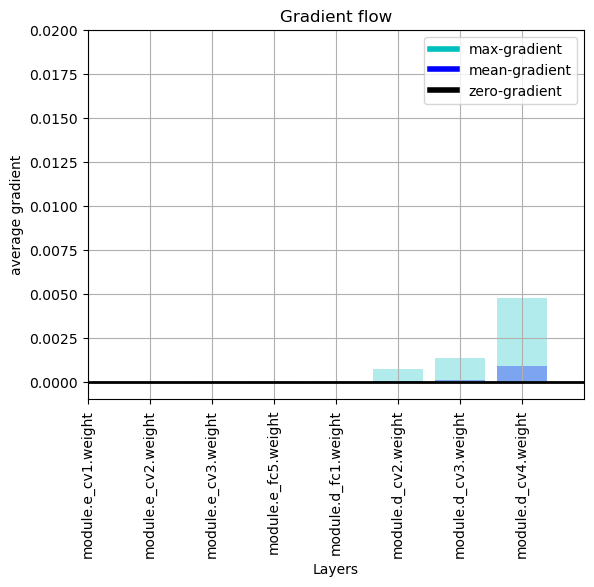

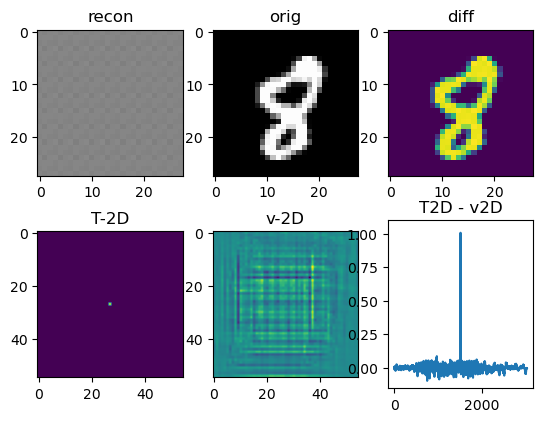

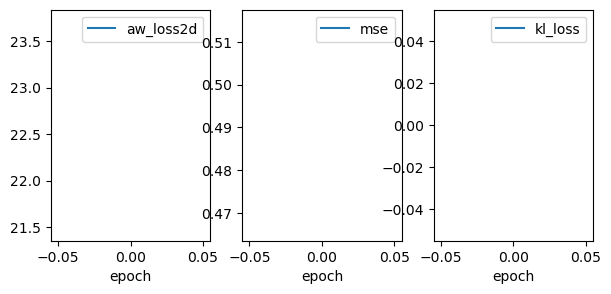

/home/dekape/miniconda3/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 20% (20 of 100) |####                   | Elapsed Time: 0:01:23 ETA:   0:05:36


 {'epoch': 20, 'train_mse': 0.5320757627487183, 'train_awi1d_loss': 21.278911590576172, 'train_kl_loss': 0.0}
 argidx T, v:  1512 1512


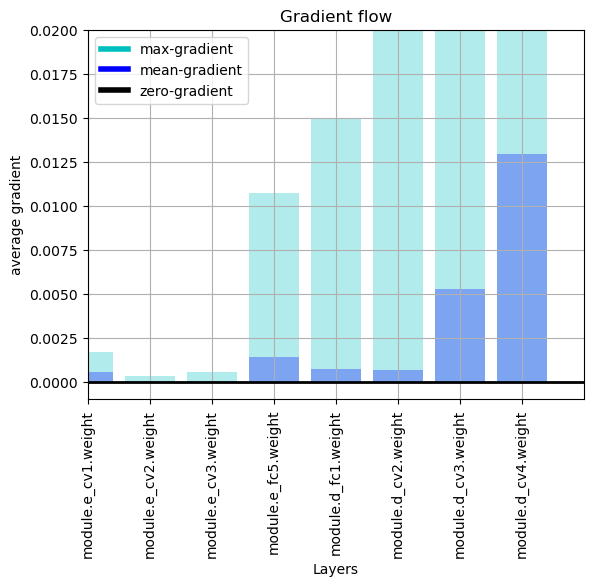

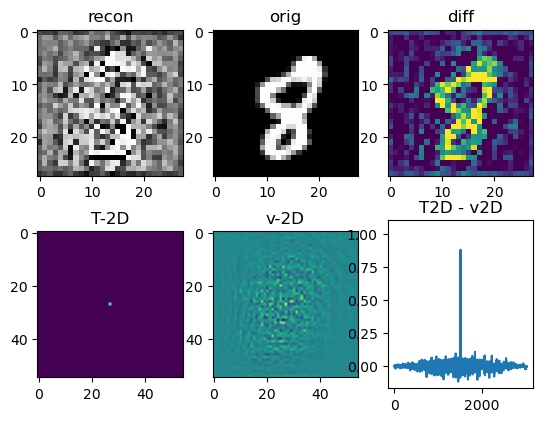

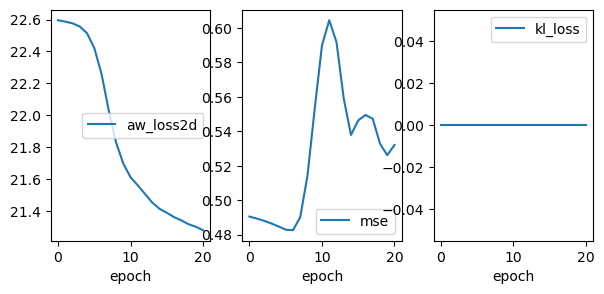

/home/dekape/miniconda3/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 40% (40 of 100) |#########              | Elapsed Time: 0:02:47 ETA:   0:04:08


 {'epoch': 40, 'train_mse': 0.399166464805603, 'train_awi1d_loss': 20.50069236755371, 'train_kl_loss': 0.0}
 argidx T, v:  1512 1512


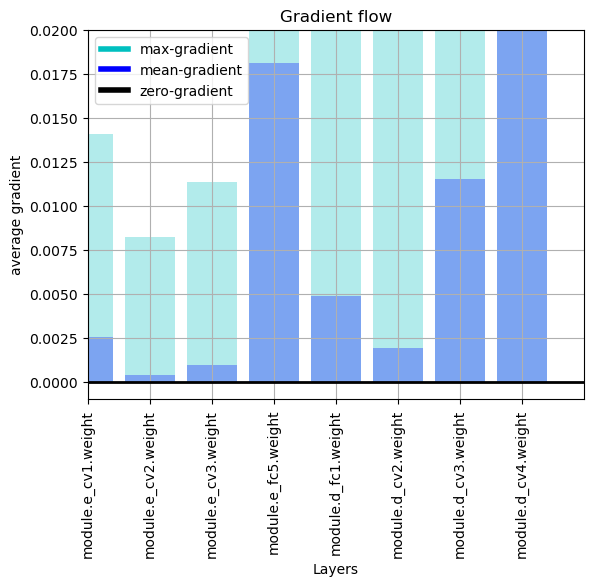

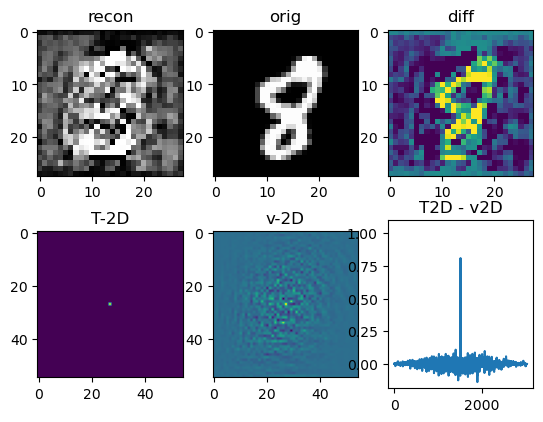

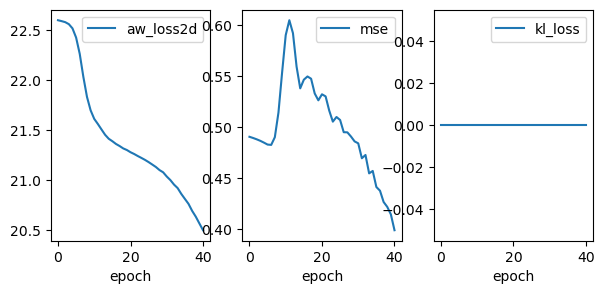

/home/dekape/miniconda3/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 60% (60 of 100) |#############          | Elapsed Time: 0:04:10 ETA:   0:02:47


 {'epoch': 60, 'train_mse': 0.28510555624961853, 'train_awi1d_loss': 19.091354370117188, 'train_kl_loss': 0.0}
 argidx T, v:  1512 1512


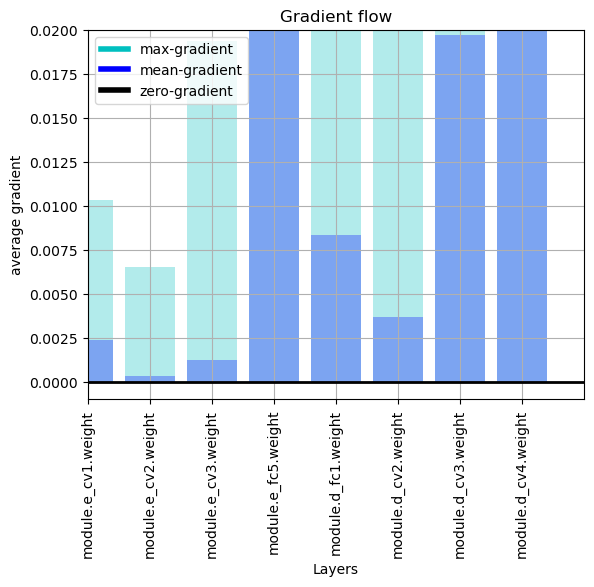

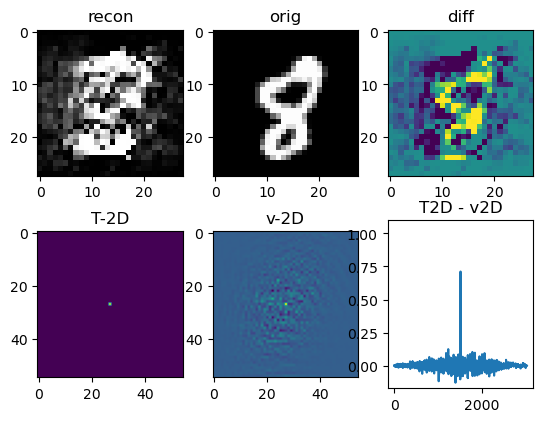

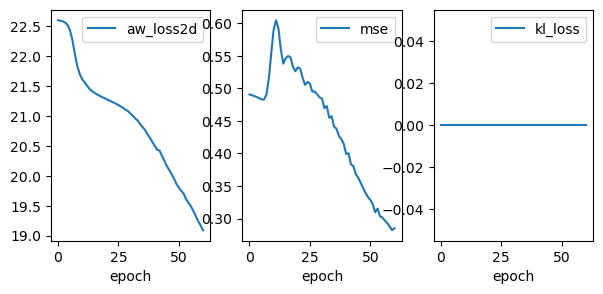

/home/dekape/miniconda3/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 80% (80 of 100) |##################     | Elapsed Time: 0:05:34 ETA:   0:01:21


 {'epoch': 80, 'train_mse': 0.23659062385559082, 'train_awi1d_loss': 18.008399963378906, 'train_kl_loss': 0.0}
 argidx T, v:  1512 1512


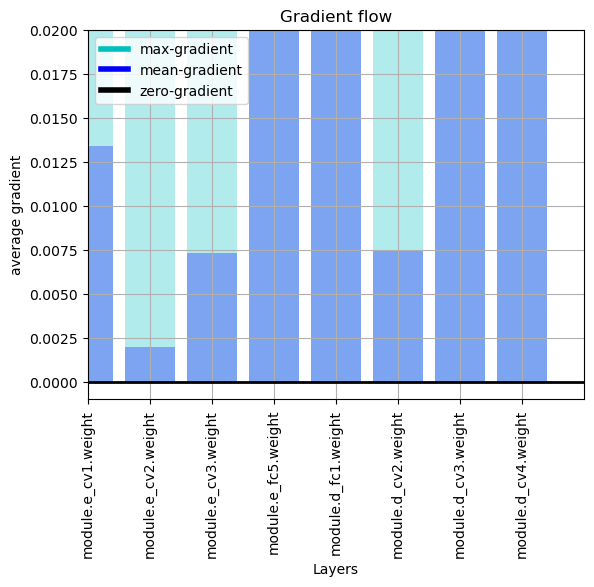

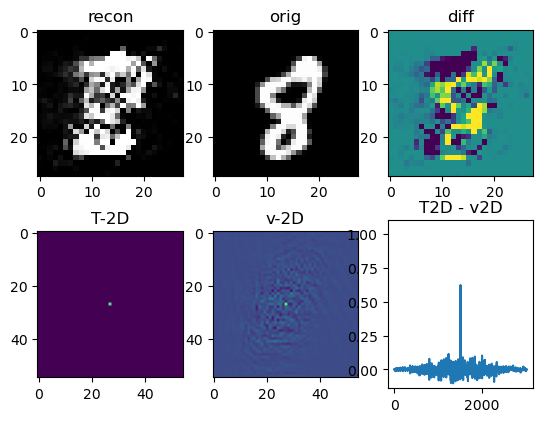

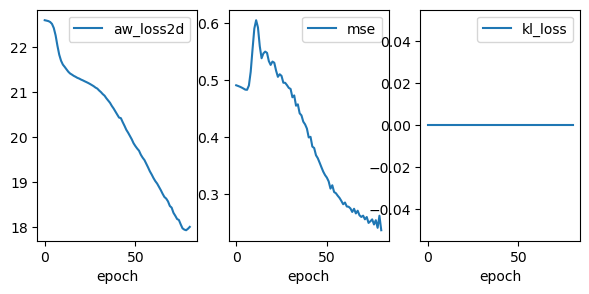

/home/dekape/miniconda3/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 99% (99 of 100) |###################### | Elapsed Time: 0:06:53 ETA:   0:00:04


 {'epoch': 99, 'train_mse': 0.23088166117668152, 'train_awi1d_loss': 16.80413055419922, 'train_kl_loss': 0.0}
 argidx T, v:  1512 1512


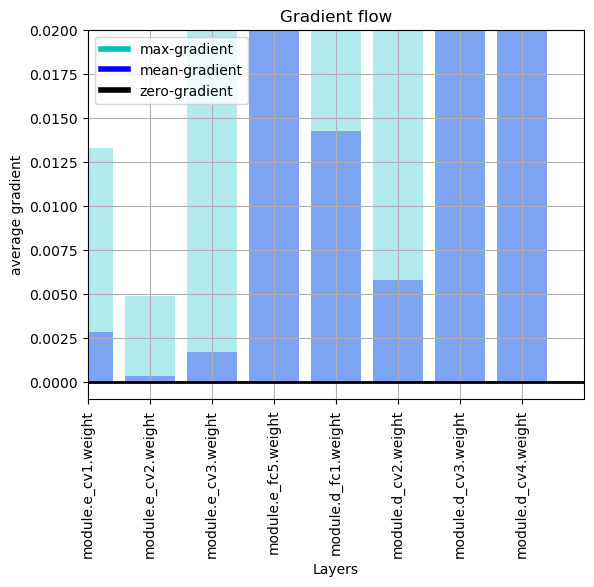

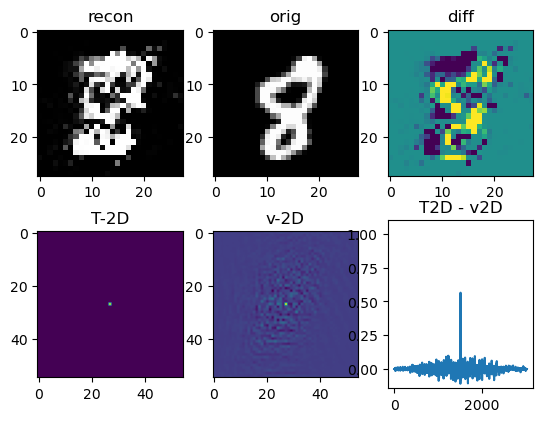

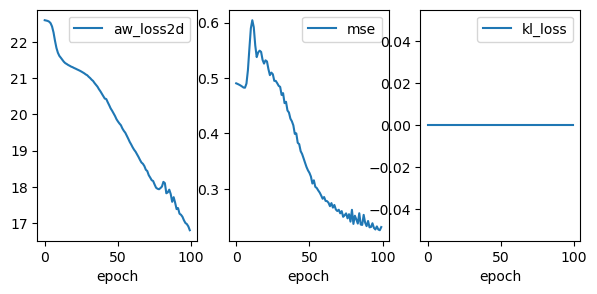

100% (100 of 100) |######################| Elapsed Time: 0:06:54 Time:  0:06:54


In [28]:
# Model and optimisers
model = CAE28(dims_latent=dims_latent, nc=X.shape[1]).to(device)
model = DataParallelModel(model, device_ids=[0,1])
awi2D_serial     = AWLoss2D(reduction="sum", std=1e-4, store_filters=True, alpha=0.02)
awi2D            = DataParallelCriterion(awi2D_serial, device_ids=[0,1])
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X)[0].shape)
print(len(model(X)))

# Train and visualise
train_model(model, optimizer, train_loader, nepochs, vis_frequency=20)


### Around 30% reduction in training time using 2 GPUs!
